# Home Loan Approval/Denial: Models, part B: Ensembles

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn import set_config

set_config(display="diagram")

In [3]:
# Local functions
from modeling_preparation import get_X_y

#### Auxiliary variables

In [4]:
filename_input = "data-hdma-eastbay-2019-2022-processed"

## Loading the processed data

In [5]:
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = get_X_y(
    filename_input, ohe_transform=False
)
X_train, X_test, y_train, y_test = get_X_y(filename_input, ohe_transform=True)

In [6]:
categorical_features = X_scaled_train.select_dtypes(include=object).columns
for col in list(categorical_features):
    X_scaled_train[col] = X_scaled_train[col].astype("category")
    X_scaled_test[col] = X_scaled_test[col].astype("category")

## Models

### HistGradientBoostingClassifier

In [7]:
model = HistGradientBoostingClassifier(
    categorical_features=categorical_features,
    validation_fraction=0.2,
    # verbose=4,
    # class_weight="balanced",
    max_iter=200,
    max_leaf_nodes=12,
    early_stopping=True,
    scoring="balanced_accuracy",
    l2_regularization=0.1,
    n_iter_no_change=10,
    learning_rate=0.1,
    max_depth=6,
)
model.fit(X_scaled_train, y_scaled_train)

HistGradientBoostingClassifier(categorical_features=Index(['applicant_sex', 'applicant_race', 'applicant_ethnicity',
       'applicant_age', 'loan_purpose', 'loan_type'],
      dtype='object'),
                               early_stopping=True, l2_regularization=0.1,
                               max_depth=6, max_iter=200, max_leaf_nodes=12,
                               scoring='balanced_accuracy',
                               validation_fraction=0.2)

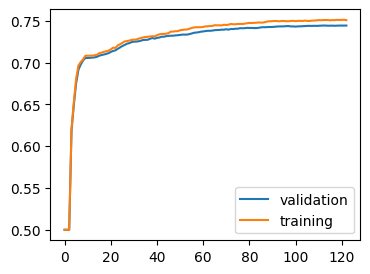

In [8]:
plt.figure(figsize=(4, 3))
plt.plot(model.validation_score_, label="validation")
plt.plot(model.train_score_, label="training")
plt.legend()
plt.show()

In [9]:
model.train_score_.max()

0.7512956219062905

In [10]:
model.validation_score_.max()

0.7444073906421664

In [11]:
histgrad_preds = model.predict(X_scaled_test)
print(classification_report(y_scaled_test, histgrad_preds))

              precision    recall  f1-score   support

           0       0.82      0.56      0.66     22501
           1       0.80      0.94      0.86     43280

    accuracy                           0.81     65781
   macro avg       0.81      0.75      0.76     65781
weighted avg       0.81      0.81      0.80     65781



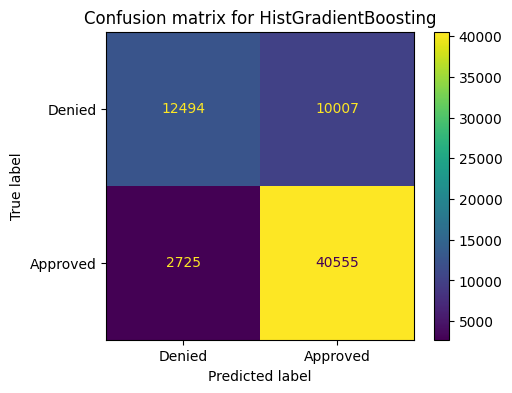

In [12]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_scaled_test,
    histgrad_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for HistGradientBoosting")
plt.show()

In [13]:
np.savetxt('results/y_test_preds-HistGradBoost.csv', model.predict_proba(X_scaled_test), delimiter=',', header='0,1')

## AdaBoost

In [14]:
model_adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
model_adaboost.fit(X_train, y_train)

/home/henrique/mlai-course/.venv/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.1, n_estimators=100)

In [15]:
print(f"test score = {model_adaboost.score(X_test, y_test)}")
print(f"train score = {model_adaboost.score(X_train, y_train)}")
adaboost_preds = model_adaboost.predict(X_test)
print(classification_report(y_test, adaboost_preds))

test score = 0.7884495523023365
train score = 0.7845406095669963
              precision    recall  f1-score   support

           0       0.85      0.46      0.60     22501
           1       0.77      0.96      0.86     43280

    accuracy                           0.79     65781
   macro avg       0.81      0.71      0.73     65781
weighted avg       0.80      0.79      0.77     65781



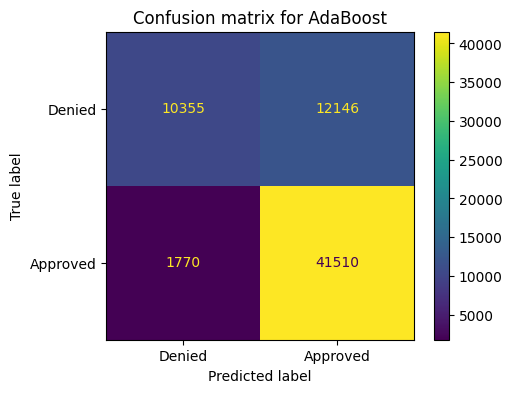

In [16]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_scaled_test,
    adaboost_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for AdaBoost")
plt.show()

In [17]:
np.savetxt('results/y_test_preds-AdaBoost.csv', model_adaboost.predict_proba(X_test), delimiter=',', header='0,1')

## Random Forest

In [18]:
grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(oob_score=True, n_jobs=1),
    param_grid={
        "n_estimators": [300],
        "criterion": ["log_loss"],
        "max_depth": [8],
        # 'min_samples_split': [2, 4, 8, 16],
        "max_features": [None],
        "ccp_alpha": [0],
        "class_weight": [None],  # None, "balanced", "balanced_subsample"
    },
    n_jobs=4,
    cv=4,
    # verbose=4,
).fit(X_train, y_train)

In [19]:
print(f"test score = {grid_rf.score(X_test, y_test)}")
print(f"train score = {grid_rf.score(X_train, y_train)}")
grid_rf_preds = grid_rf.predict(X_test)
print(classification_report(y_test, grid_rf_preds))

test score = 0.797038658579225
train score = 0.7977991478050115
              precision    recall  f1-score   support

           0       0.86      0.49      0.62     22501
           1       0.78      0.96      0.86     43280

    accuracy                           0.80     65781
   macro avg       0.82      0.72      0.74     65781
weighted avg       0.81      0.80      0.78     65781



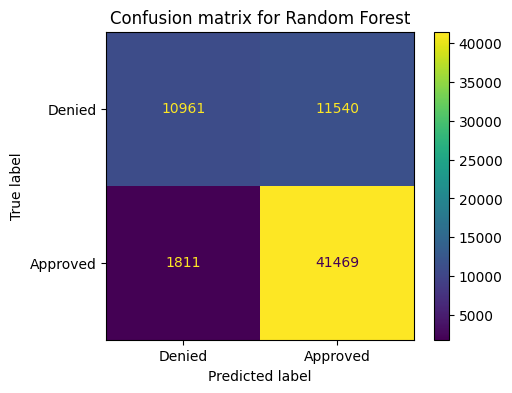

In [20]:
f, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(
    y_scaled_test,
    grid_rf_preds,
    values_format="d",
    display_labels=["Denied", "Approved"],
    ax=ax,
)
plt.title("Confusion matrix for Random Forest")
plt.show()

In [21]:
np.savetxt('results/y_test_preds-RandomForest.csv', grid_rf.predict_proba(X_test), delimiter=',', header='0,1')